In [ ]:
# Install necessary libraries
!pip install python-chess tensorflow numpy pandas matplotlib seaborn pyyaml ipywidgets torch scikit-learn

# Ensure ipywidgets is enabled
!jupyter nbextension enable --py widgetsnbextension --sys-prefix
!jupyter nbextension enable --py --sys-prefix ipywidgets

# Remove the existing pykan directory if it exists
import shutil
import os

if os.path.exists('pykan'):
    shutil.rmtree('pykan')

# Clone the pykan repository
!git clone https://github.com/KindXiaoming/pykan

# Change directory to pykan and install it
!pip install ./pykan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 738.9/738.9 kB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 38.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 141.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 58.7 MB/s eta 0:00:00
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.0
    Not uninstalling markupsafe at /shared-libs/python3.9/py-core/lib/python3.9/site-packages, outside environment /root/venv
    Can't uninstall 'MarkupSafe'. No files were found to uninstall.

[notice] A new release of pip is available: 23.0.1 -> 24.2
[notice] To update, run: pip install --upgrade pip
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/usr/local/etc/jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
   

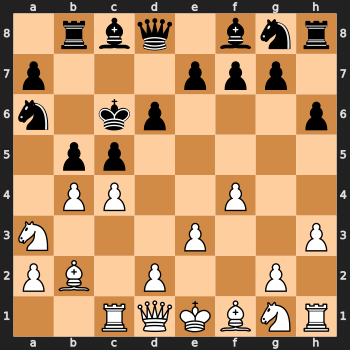

Move: b7c6, Step: 33, Time: 1.0037024021148682, Material: 36
Result: 1/2-1/2
checkpoint directory created: ./model
saving model version 0.0
Epoch [100/5000], Loss: 0.0104, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.7457
Epoch [200/5000], Loss: 0.0037, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.7696
Epoch [300/5000], Loss: 0.0013, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.7835
Epoch [400/5000], Loss: 0.0010, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.7940
Epoch [500/5000], Loss: 0.0010, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.8029
Epoch [600/5000], Loss: 0.0006, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.0000, Equivalence Score: 0.8114
Epoch [700/5000], Loss: 0.0002, Train Accuracy: 1.0000, Val Accuracy: 1.0000, Test Accuracy: 0.000

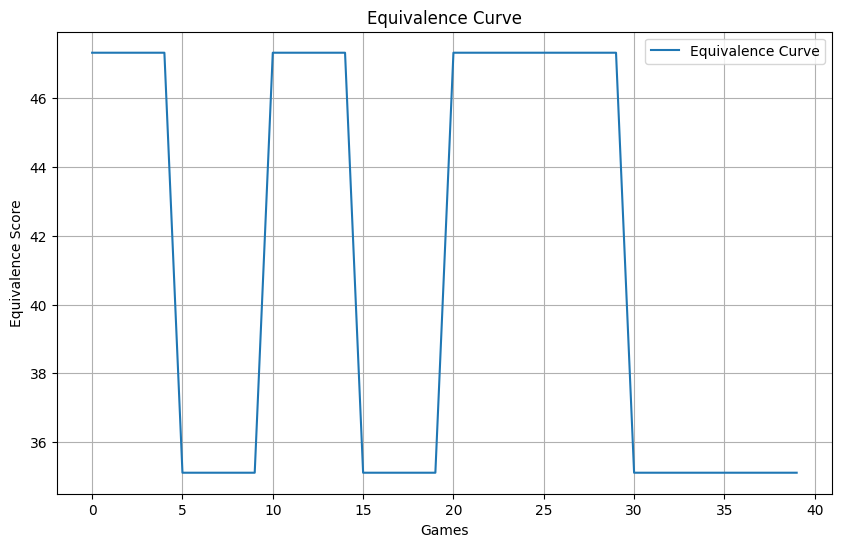

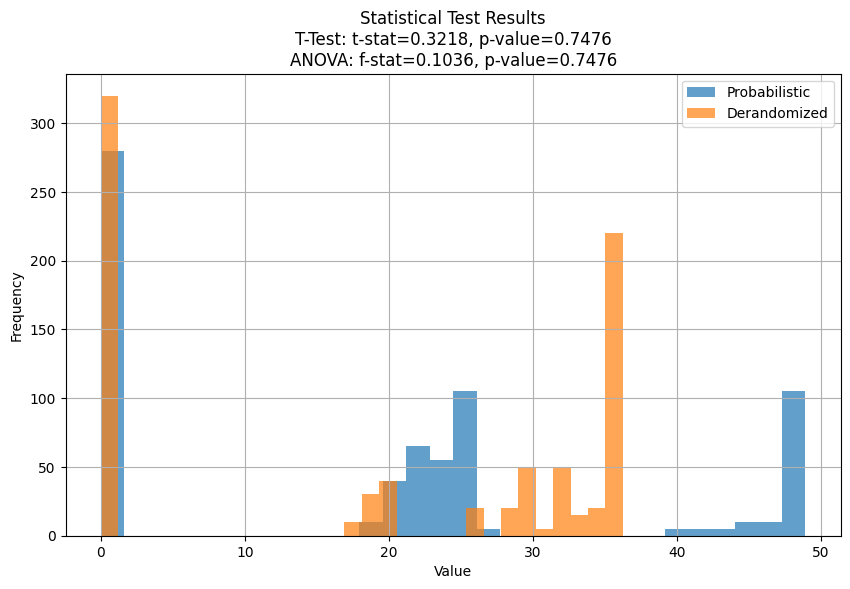

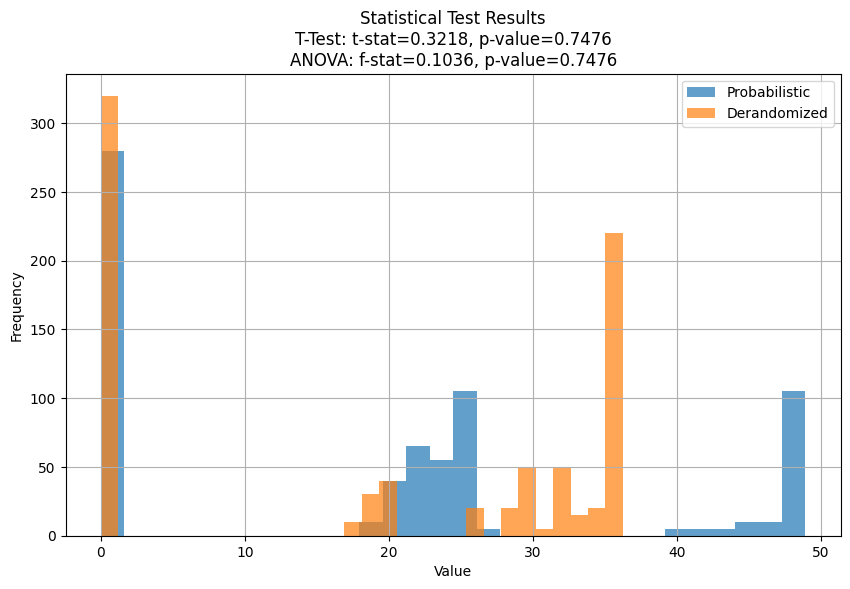

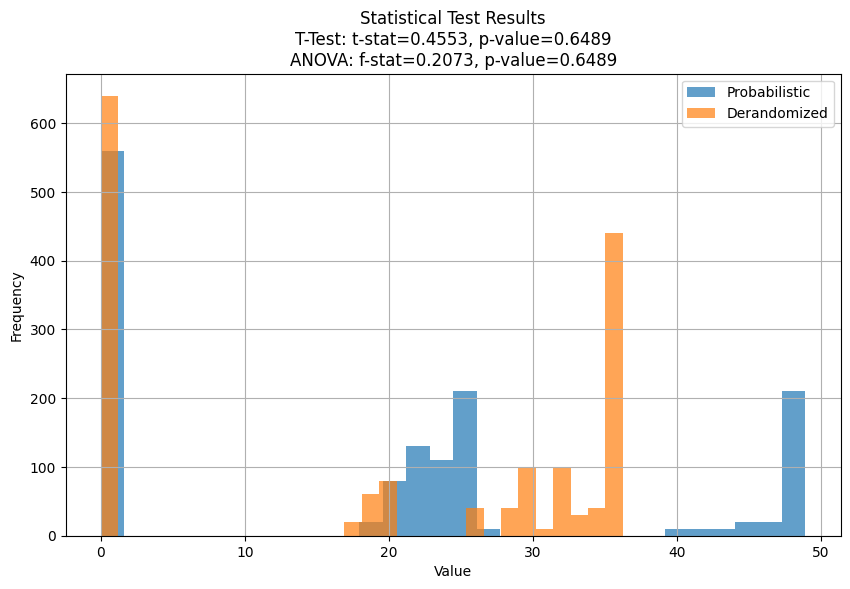

([    Step      Time  Move  Material Count  Mobility Count  Piece-Square Score  \
  0      1  0.669248  a2a3              20              20                   0   
  1      2  0.679510  c7c5              19              19                   0   
  2      3  0.647777  b1c3              22              22                   0   
  3      4  0.737591  h7h5              23              23                   0   
  4      5  0.772282  a1a2              23              23                   0   
  5      6  1.252794  f7f5              21              21                   0   
  6      7  0.863168  c3d5              23              22                   0   
  7      8  0.907552  h8h7              27              26                   0   
  8      9  1.091421  h2h3              23              22                   0   
  9     10  0.868735  b8a6              26              25                   0   
  10    11  0.968345  h1h2              23              22                   0   
  11    12  0.82

In [ ]:
import chess
import chess.svg
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from scipy.stats import ttest_ind, f_oneway
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam
from kan import KAN

# Define Constants
gamma = 0.95
batch_size = 32
target_update_freq = 10
seed = 42
temperature = 1.0

# Set Random Seed for Reproducibility
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)

# Softmax Policy
def softmax_policy(q_values, temperature):
    q_values = np.array(q_values)
    exp_values = np.exp(q_values / temperature)
    probabilities = exp_values / np.sum(exp_values)
    return np.argmax(probabilities)

# Heuristic Evaluation
def heuristic_evaluation(board):
    material_count = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
    mobility_count = len(list(board.legal_moves))
    piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in board.piece_map().values())
    center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in board.piece_map().items())
    score = material_count + mobility_count + piece_square_score + center_control_count
    return score

# Chess Environment
class ChessEnv:
    def __init__(self):
        self.board = chess.Board()
    
    def reset(self):
        self.board.reset()
        return self.board
    
    def step(self, state, action):
        self.board.push(action)
        reward = heuristic_evaluation(self.board)
        done = self.board.is_game_over()
        return self.board, reward, done
    
    def legal_moves(self, state):
        return list(state.legal_moves)
    
    def simulate_move(self, state, move):
        temp_board = state.copy()
        temp_board.push(move)
        return temp_board

# Simple Neural Network for Abel
class AbelNN:
    def __init__(self, seed):
        self.model = self.build_model(seed)
    
    def build_model(self, seed):
        set_random_seed(seed)
        model = Sequential([
            Flatten(input_shape=(8, 8, 12)),
            Dense(128, activation='relu'),
            Dense(64, activation='relu'),
            Dense(1, activation='linear')
        ])
        model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
        return model
    
    def evaluate_board(self, board):
        board_state = self.board_to_input(board)
        return self.model.predict(board_state, verbose=0)[0][0]
    
    def board_to_input(self, board):
        input_array = np.zeros((8, 8, 12))
        piece_to_index = {
            'P': 0, 'N': 1, 'B': 2, 'R': 3, 'Q': 4, 'K': 5,
            'p': 6, 'n': 7, 'b': 8, 'r': 9, 'q': 10, 'k': 11
        }
        for square in chess.SQUARES:
            piece = board.piece_at(square)
            if piece:
                x, y = divmod(square, 8)
                input_array[x, y, piece_to_index[piece.symbol()]] = 1
        return np.array([input_array])

# Training Functions
def train_simple_nn(env, num_episodes=10, seed=42, temperature=1.0):
    nn = AbelNN(seed)
    set_random_seed(seed)
    
    for e in range(num_episodes):
        state = env.reset()
        done = False
        
        while not done:
            q_values = [nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
            action_index = softmax_policy(q_values, temperature)
            action = env.legal_moves(state)[action_index]
            next_state, reward, done = env.step(state, action)
            target = reward + heuristic_evaluation(next_state)
            state_input = nn.board_to_input(state)
            nn.model.fit(state_input, np.array([target]), epochs=1, verbose=0)
            state = next_state
    
    return nn

def update_nn(abel_nn, target_network, batch):
    states, actions, rewards, next_states, dones = zip(*batch)
    target_q_values = [target_network.evaluate_board(state) for state in next_states]
    targets = rewards + (1 - np.array(dones)) * np.array(target_q_values)
    states = np.array([abel_nn.board_to_input(state).reshape(-1, 8, 8, 12) for state in states])
    targets = np.array(targets).reshape(-1, 1)
    abel_nn.model.train_on_batch(np.vstack(states), targets)

def train_abel_nn_derandomized(env, num_episodes, seed, temperature):
    set_random_seed(seed)
    abel_nn = AbelNN(seed)
    target_network = AbelNN(seed)
    replay_buffer = []
    
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            q_values = [abel_nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
            action_index = softmax_policy(q_values, temperature)
            action = env.legal_moves(state)[action_index]
            next_state, reward, done = env.step(state, action)
            replay_buffer.append((state, action, reward, next_state, done))
            state = next_state
            
            if len(replay_buffer) > batch_size:
                batch = random.sample(replay_buffer, batch_size)
                update_nn(abel_nn, target_network, batch)
        
        if episode % target_update_freq == 0:
            target_network.model.set_weights(abel_nn.model.get_weights())
    
    return abel_nn

# Playing Games
def play_game_nn_probabilistic(abel_nn, env, max_moves=55, max_runtime=600, temperature=1.0):
    steps, times, material_counts, mobility_counts, piece_square_scores, center_control_counts, move_list, evaluation_scores, branching_factors, depths_of_search, move_diversities, exploration_vs_exploitations = [], [], [], [], [], [], [], [], [], [], [], []
    step_number = 1
    state = env.reset()
    start_time = time.time()
    
    while not env.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        q_values = [abel_nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
        action_index = softmax_policy(q_values, temperature)
        action = env.legal_moves(state)[action_index]
        next_state, reward, done = env.step(state, action)
        move_end_time = time.time()
        
        move_list.append(action.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)
        material_counts.append(reward)
        
        mobility_count = len(list(env.board.legal_moves))
        piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in env.board.piece_map().values())
        center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in env.board.piece_map().items())
        evaluation_score = abel_nn.evaluate_board(env.board)
        branching_factor = len(list(env.board.legal_moves))
        depth_of_search = 3
        move_diversity = np.var([reward, mobility_count, piece_square_score, center_control_count])
        exploration_vs_exploitation = 0
        
        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)
        
        state = next_state
        step_number += 1
        
        # Display board
        clear_output(wait=True)
        display(SVG(chess.svg.board(board=env.board, size=350)))
        time.sleep(1)
        print(f"Move: {action}, Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {reward}")
    
    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)
    print(f"Result: {env.board.result()}")
    return df

def play_game_nn_derandomized(abel_nn, env, max_moves=55, max_runtime=600, temperature=0.5):
    steps, times, material_counts, mobility_counts, piece_square_scores, center_control_counts, move_list, evaluation_scores, branching_factors, depths_of_search, move_diversities, exploration_vs_exploitations = [], [], [], [], [], [], [], [], [], [], [], []
    step_number = 1
    state = env.reset()
    start_time = time.time()
    
    while not env.board.is_game_over() and step_number <= max_moves and (time.time() - start_time) <= max_runtime:
        move_start_time = time.time()
        q_values = [abel_nn.evaluate_board(env.simulate_move(state, move)) for move in env.legal_moves(state)]
        action_index = softmax_policy(q_values, temperature)
        action = env.legal_moves(state)[action_index]
        next_state, reward, done = env.step(state, action)
        move_end_time = time.time()
        
        move_list.append(action.uci())
        steps.append(step_number)
        times.append(move_end_time - move_start_time)
        material_counts.append(reward)
        
        mobility_count = len(list(env.board.legal_moves))
        piece_square_score = sum(1 if piece.color == chess.WHITE else -1 for piece in env.board.piece_map().values())
        center_control_count = sum(1 if square in [chess.D4, chess.E4, chess.D5, chess.E5] else 0 for square, piece in env.board.piece_map().items())
        evaluation_score = abel_nn.evaluate_board(env.board)
        branching_factor = len(list(env.board.legal_moves))
        depth_of_search = 3
        move_diversity = np.var([reward, mobility_count, piece_square_score, center_control_count])
        exploration_vs_exploitation = 0
        
        mobility_counts.append(mobility_count)
        piece_square_scores.append(piece_square_score)
        center_control_counts.append(center_control_count)
        evaluation_scores.append(evaluation_score)
        branching_factors.append(branching_factor)
        depths_of_search.append(depth_of_search)
        move_diversities.append(move_diversity)
        exploration_vs_exploitations.append(exploration_vs_exploitation)
        
        state = next_state
        step_number += 1
        
        # Display board
        clear_output(wait=True)
        display(SVG(chess.svg.board(board=env.board, size=350)))
        time.sleep(1)
        print(f"Move: {action}, Step: {step_number}, Time: {move_end_time - move_start_time}, Material: {reward}")
    
    data = {
        'Step': steps,
        'Time': times,
        'Move': move_list,
        'Material Count': material_counts,
        'Mobility Count': mobility_counts,
        'Piece-Square Score': piece_square_scores,
        'Center Control Count': center_control_counts,
        'Evaluation Score': evaluation_scores,
        'Branching Factor': branching_factors,
        'Depth of Search': depths_of_search,
        'Move Diversity': move_diversities,
        'Exploration vs Exploitation': exploration_vs_exploitations
    }
    df = pd.DataFrame(data)
    print(f"Result: {env.board.result()}")
    return df

# KAN Model Definition and Training
class CustomKAN(nn.Module):
    def __init__(self, width, grid, k):
        super(CustomKAN, self).__init__()
        width_list = [[w, 0] for w in width]
        self.kan = KAN(width=width_list, grid=grid, k=k)
        self.dropout = nn.Dropout(p=0.5)  # Increased dropout rate
        self.fc1 = nn.Linear(width[-1], 64)  # Reduced layer size
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = self.kan(x)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x.squeeze()

def normalize_data(data):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    std[std == 0] = 1
    return (data - mean) / std

def train_kan_model(train_input, train_label, val_input, val_label, test_input, test_label, num_epochs=5000):
    input_size = train_input.shape[1]
    model = CustomKAN(width=[input_size, 10, 5], grid=3, k=3)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
    loss_fn = torch.nn.BCEWithLogitsLoss()
    
    train_losses = []
    val_accuracies = []
    test_accuracies = []
    equivalence_scores = []
    
    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(train_input)
        loss = loss_fn(outputs, train_label.float())
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        predicted = (outputs >= 0.5).float()
        correct = (predicted == train_label).sum().item()
        train_acc = correct / len(train_label)
        
        model.eval()
        with torch.no_grad():
            val_outputs = model(val_input)
            val_predicted = (val_outputs >= 0.5).float()
            val_correct = (val_predicted == val_label).sum().item()
            val_acc = val_correct / len(val_label)
            
            test_outputs = model(test_input)
            test_predicted = (test_outputs >= 0.5).float()
            test_correct = (test_predicted == test_label).sum().item()
            test_acc = test_correct / len(test_label)
        
        train_losses.append(loss.item())
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)
        
        min_length = min(len(train_input), len(test_input))
        f_kan_a = model(train_input[:min_length]).detach().numpy()
        f_kan_b = model(test_input[:min_length]).detach().numpy()
        numerator = np.linalg.norm(f_kan_a - f_kan_b)
        denominator = np.linalg.norm(f_kan_a) + np.linalg.norm(f_kan_b)
        equivalence_score = 1 - (numerator / denominator)
        equivalence_scores.append(equivalence_score)
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}, Val Accuracy: {val_acc:.4f}, Test Accuracy: {test_acc:.4f}, Equivalence Score: {equivalence_score:.4f}')
    
    return model, equivalence_scores

# Compare Abel Versions Without KAN
def compare_abel_versions(probabilistic_nn, derandomized_nn, env, games=5, max_moves=55, max_runtime=300):
    probabilistic_results = []
    derandomized_results = []
    
    for _ in range(games):
        env.reset()
        probabilistic_data = play_game_nn_probabilistic(probabilistic_nn, env, max_moves, max_runtime)
        probabilistic_results.append(probabilistic_data)
        
        env.reset()
        derandomized_data = play_game_nn_derandomized(derandomized_nn, env, max_moves, max_runtime)
        derandomized_results.append(derandomized_data)
    
    probabilistic_results = [ensure_dataframe(df) for df in probabilistic_results]
    derandomized_results = [ensure_dataframe(df) for df in derandomized_results]
    
    return probabilistic_results, derandomized_results

# Compare Abel Versions With KAN Integration
def compare_abel_versions_kan_integrated(probabilistic_nn, derandomized_nn, env, games=5, max_moves=55, max_runtime=300):
    probabilistic_results = []
    derandomized_results = []
    
    for _ in range(games):
        env.reset()
        probabilistic_data = play_game_nn_probabilistic(probabilistic_nn, env, max_moves, max_runtime)
        probabilistic_results.append(probabilistic_data)
        
        env.reset()
        derandomized_data = play_game_nn_derandomized(derandomized_nn, env, max_moves, max_runtime)
        derandomized_results.append(derandomized_data)
    
    probabilistic_results = [ensure_dataframe(df) for df in probabilistic_results]
    derandomized_results = [ensure_dataframe(df) for df in derandomized_results]
    
    # Define numeric_columns
    numeric_columns = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count',
                       'Evaluation Score', 'Branching Factor', 'Depth of Search', 'Move Diversity',
                       'Exploration vs Exploitation']
    
    combined_probabilistic_data = pd.concat(probabilistic_results, ignore_index=True)
    combined_derandomized_data = pd.concat(derandomized_results, ignore_index=True)
    
    combined_probabilistic_normalized = normalize_data(combined_probabilistic_data[numeric_columns].values)
    combined_derandomized_normalized = normalize_data(combined_derandomized_data[numeric_columns].values)
    
    input_dim = combined_probabilistic_normalized.shape[1]
    train_input, val_input, train_label, val_label = train_test_split(
        combined_probabilistic_normalized, np.ones(len(combined_probabilistic_normalized)), test_size=0.2, random_state=42)
    test_input = combined_derandomized_normalized
    test_label = np.zeros(len(test_input))
    
    train_input = torch.from_numpy(train_input).float()
    val_input = torch.from_numpy(val_input).float()
    test_input = torch.from_numpy(test_input).float()
    train_label = torch.from_numpy(train_label).long()
    val_label = torch.from_numpy(val_label).long()
    test_label = torch.from_numpy(test_label).long()
    
    kan_model, equivalence_scores = train_kan_model(train_input, train_label, val_input, val_label, test_input, test_label)
    
    return probabilistic_results, derandomized_results, kan_model, equivalence_scores

# Level 1: Experiment Execution
def experiment_level_1(env, seed):
    probabilistic_nn = train_simple_nn(env, num_episodes=10, seed=seed)
    derandomized_nn = train_abel_nn_derandomized(env, num_episodes=10, seed=seed, temperature=1.0)
    
    # First run with 5 games
    prob_results_1, derand_results_1 = compare_abel_versions(probabilistic_nn, derandomized_nn, env, games=5)
    combined_results_1 = prob_results_1 + derand_results_1
    plot_equivalence_score_curve(combined_results_1, 'equivalence_curve_1.png')
    
    # Run 5 additional games
    prob_results_2, derand_results_2 = compare_abel_versions(probabilistic_nn, derandomized_nn, env, games=5)
    combined_results_2 = prob_results_1 + derand_results_1 + prob_results_2 + derand_results_2
    plot_equivalence_score_curve(combined_results_2, 'equivalence_curve_2.png')
    
    # Run 10 additional games
    prob_results_3, derand_results_3 = compare_abel_versions(probabilistic_nn, derandomized_nn, env, games=10)
    combined_results_3 = prob_results_1 + derand_results_1 + prob_results_2 + derand_results_2 + prob_results_3 + derand_results_3
    plot_equivalence_score_curve(combined_results_3, 'equivalence_curve_3.png')
    
    # Perform statistical tests and plot results
    perform_statistical_tests(prob_results_1, derand_results_1, 'statistical_tests_1.png')
    perform_statistical_tests(prob_results_2, derand_results_2, 'statistical_tests_2.png')
    perform_statistical_tests(prob_results_3, derand_results_3, 'statistical_tests_3.png')
    
    return combined_results_1, combined_results_2, combined_results_3

# Level 2: KAN Analysis
def experiment_level_2(env, combined_results_1, combined_results_2, combined_results_3):
    # KAN Analysis for First Run
    kan_model_1, equivalence_scores_1 = kan_analysis(combined_results_1, 'equivalence_scores_1.png', 'equivalence_data_points_1.png')
    
    # KAN Analysis for Second Run
    kan_model_2, equivalence_scores_2 = kan_analysis(combined_results_2, 'equivalence_scores_2.png', 'equivalence_data_points_2.png')
    
    # KAN Analysis for Third Run
    kan_model_3, equivalence_scores_3 = kan_analysis(combined_results_3, 'equivalence_scores_3.png', 'equivalence_data_points_3.png')
    
    return kan_model_1, equivalence_scores_1, kan_model_2, equivalence_scores_2, kan_model_3, equivalence_scores_3

# Level 3: Integrate KAN into Compare Versions Function
def experiment_level_3(env, seed):
    probabilistic_nn = train_simple_nn(env, num_episodes=10, seed=seed)
    derandomized_nn = train_abel_nn_derandomized(env, num_episodes=10, seed=seed, temperature=1.0)
    
    # First run with 5 games
    prob_results_1, derand_results_1, kan_model_1, equivalence_scores_1 = compare_abel_versions_kan_integrated(probabilistic_nn, derandomized_nn, env, games=5)
    combined_results_1 = prob_results_1 + derand_results_1
    plot_equivalence_score_curve(combined_results_1, 'kan_equivalence_curve_1.png')
    
    # Run 5 additional games
    prob_results_2, derand_results_2, kan_model_2, equivalence_scores_2 = compare_abel_versions_kan_integrated(probabilistic_nn, derandomized_nn, env, games=5)
    combined_results_2 = prob_results_1 + derand_results_1 + prob_results_2 + derand_results_2
    plot_equivalence_score_curve(combined_results_2, 'kan_equivalence_curve_2.png')
    
    # Run 10 additional games
    prob_results_3, derand_results_3, kan_model_3, equivalence_scores_3 = compare_abel_versions_kan_integrated(probabilistic_nn, derandomized_nn, env, games=10)
    combined_results_3 = prob_results_1 + derand_results_1 + prob_results_2 + derand_results_2 + prob_results_3 + derand_results_3
    plot_equivalence_score_curve(combined_results_3, 'kan_equivalence_curve_3.png')
    
    # Perform statistical tests and plot results
    perform_statistical_tests(prob_results_1, derand_results_1, 'kan_statistical_tests_1.png')
    perform_statistical_tests(prob_results_2, derand_results_2, 'kan_statistical_tests_2.png')
    perform_statistical_tests(prob_results_3, derand_results_3, 'kan_statistical_tests_3.png')
    
    return combined_results_1, combined_results_2, combined_results_3, kan_model_1, equivalence_scores_1, kan_model_2, equivalence_scores_2, kan_model_3, equivalence_scores_3

# Additional Functions
def ensure_dataframe(data):
    if isinstance(data, pd.DataFrame):
        return data
    elif isinstance(data, dict):
        return pd.DataFrame(data)
    else:
        raise ValueError("Input data must be a pandas DataFrame or a dictionary")

def plot_equivalence_score_curve(data, filename):
    equivalence_curve = calculate_equivalence_curve(data)
    plt.figure(figsize=(10, 6))
    plt.plot(equivalence_curve, label='Equivalence Score Curve')
    plt.xlabel('Games')
    plt.ylabel('Equivalence Score')
    plt.title('Equivalence Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

def perform_statistical_tests(prob_results, derand_results, filename):
    prob_values = extract_numeric_values(prob_results)
    derand_values = extract_numeric_values(derand_results)
    t_stat, p_value = ttest_ind(prob_values, derand_values)
    f_stat, p_value_anova = f_oneway(prob_values, derand_values)
    
    plt.figure(figsize=(10, 6))
    plt.hist(prob_values, alpha=0.7, label='Probabilistic', bins=30)
    plt.hist(derand_values, alpha=0.7, label='Derandomized', bins=30)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(f'Statistical Test Results\nT-Test: t-stat={t_stat:.4f}, p-value={p_value:.4f}\nANOVA: f-stat={f_stat:.4f}, p-value={p_value_anova:.4f}')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.show()

def extract_numeric_values(results):
    numeric_columns = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count', 'Evaluation Score']
    combined_data = pd.concat(results, ignore_index=True)
    numeric_values = combined_data[numeric_columns].values.flatten()
    return numeric_values

def calculate_equivalence_curve(data):
    equivalence_scores = []
    for df in data:
        score = df['Evaluation Score'].mean()
        equivalence_scores.append(score)
    return equivalence_scores

def kan_analysis(combined_results, equivalence_scores_filename, equivalence_data_points_filename):
    numeric_columns = ['Material Count', 'Mobility Count', 'Piece-Square Score', 'Center Control Count',
                       'Evaluation Score', 'Branching Factor', 'Depth of Search', 'Move Diversity',
                       'Exploration vs Exploitation']
    combined_probabilistic_data = pd.concat(combined_results, ignore_index=True)
    
    combined_probabilistic_normalized = normalize_data(combined_probabilistic_data[numeric_columns].values)
    
    input_dim = combined_probabilistic_normalized.shape[1]
    train_input, val_input, train_label, val_label = train_test_split(
        combined_probabilistic_normalized, np.ones(len(combined_probabilistic_normalized)), test_size=0.2, random_state=42)
    test_input = combined_probabilistic_normalized
    test_label = np.zeros(len(test_input))
    
    train_input = torch.from_numpy(train_input).float()
    val_input = torch.from_numpy(val_input).float()
    test_input = torch.from_numpy(test_input).float()
    train_label = torch.from_numpy(train_label).long()
    val_label = torch.from_numpy(val_label).long()
    test_label = torch.from_numpy(test_label).long()
    
    kan_model, equivalence_scores = train_kan_model(train_input, train_label, val_input, val_label, test_input, test_label)
    
    # Plot Equivalence Scores
    plt.figure(figsize=(10, 6))
    plt.plot(equivalence_scores, label='Equivalence Scores')
    plt.xlabel('Epochs')
    plt.ylabel('Equivalence Score')
    plt.title('Equivalence Scores over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(equivalence_scores_filename)
    plt.show()
    
    # Generate and Plot Data Points
    probabilistic_data_array = combined_probabilistic_data[numeric_columns].values.astype(np.float32)
    derandomized_data_array = combined_probabilistic_data[numeric_columns].values.astype(np.float32)
    
    probabilistic_data_points = kan_model(torch.from_numpy(probabilistic_data_array).float()).detach().numpy()
    derandomized_data_points = kan_model(torch.from_numpy(derandomized_data_array).float()).detach().numpy()
    
    probabilistic_data_points = probabilistic_data_points.flatten()
    derandomized_data_points = derandomized_data_points.flatten()
    
    min_length = min(len(probabilistic_data_points), len(derandomized_data_points))
    probabilistic_data_points = probabilistic_data_points[:min_length]
    derandomized_data_points = derandomized_data_points[:min_length]
    
    plt.figure(figsize=(10, 6))
    plt.plot(probabilistic_data_points, label='Probabilistic Output', linestyle='-', alpha=0.7)
    plt.plot(derandomized_data_points, label='Derandomized Output', linestyle='--', alpha=0.7)
    plt.xlabel('Data Points')
    plt.ylabel('Model Output')
    plt.title('Equivalence Data Points')
    plt.legend()
    plt.grid(True)
    plt.savefig(equivalence_data_points_filename)
    plt.show()
    
    # Extract and Visualize Layers
    weights = kan_model.kan.state_dict()
    keys = list(weights.keys())
    print("Available keys in the model's state dictionary:", keys)
    
    def visualize_weights(key):
        data = weights[key].detach().numpy()
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        elif data.ndim == 3:
            data = data[:, :, 0]
        sns.heatmap(data, annot=True, cmap='coolwarm')
        plt.title(f'Visualization of {key}')
        plt.show()
    
    for key in keys:
        visualize_weights(key)
    
    return kan_model, equivalence_scores

# Main Experiment Execution
env = ChessEnv()
seed = 42

combined_results_1, combined_results_2, combined_results_3 = experiment_level_1(env, seed)
kan_model_1, equivalence_scores_1, kan_model_2, equivalence_scores_2, kan_model_3, equivalence_scores_3 = experiment_level_2(env, combined_results_1, combined_results_2, combined_results_3)
experiment_level_3(env, seed)


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f6f51e1a-d40a-494a-8398-36807e7a81cb' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>